In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [16]:
import pandas as pd
import os
from scipy import stats
import loadmat
%pylab inline
import scipy.io as spio
import matplotlib.gridspec as gridspec
import fdr_correct

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [17]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
savedir = os.path.join(SJdir, 'PCA', 'Figures')
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/Figures'

# traces grouped by RT in bins of 50ms
* without my data
* dropped SR

In [18]:
#load data (without my data, without SR)
p = 'D'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata, allRTs, allsubjs, alltasks, alloffsets = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs)
allRTs = allRTs[i]
alldata = alldata[i,:]
allsubjs = allsubjs[i]
alltasks = alltasks[i]
alloffsets = alloffsets[i]

p = 'R'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata_resp, allRTs_resp, allsubjs_resp, alltasks_resp, alloffsets_resp = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs_resp)
allRTs_resp = allRTs_resp[i]
alldata_resp = alldata_resp[i,:]
allsubjs_resp = allsubjs_resp[i]
alltasks_resp = alltasks_resp[i]
alloffsets_resp = alloffsets_resp[i]

In [259]:
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
cnt = 0
for s_t in df.groupby(('subj','task')):
    subj, task = s_t[0]
    print '%s %s %i' %(subj, task, sum([alltasks == task][0] * [allsubjs == subj][0]))
    cnt += sum([alltasks == task][0] * [allsubjs == subj][0])
    
print cnt

CP7 DecisionAud 0
CP9 DecisionAud 0
GP15 EmoGen 2499
GP15 EmoRep 570
GP15 FaceEmo 917
GP15 FaceGen 786
GP15 SelfAud 410
GP15 SelfVis 616
GP28 SelfAud 222
GP28 SelfVis 0
GP35 EmoGen 1530
GP35 EmoRep 850
GP35 FaceEmo 832
GP35 FaceGen 498
JH10 EmoRep 0
JH10 SelfAud 244
JH17 EmoRep 0
JH17 SelfAud 732
JH17 SelfVis 1088
JH2 EmoGen 1071
JH2 FaceEmo 1808
JH2 SelfAud 513
JH2 SelfVis 350
JH5 EmoRep 408
JH6 FaceEmo 784
JH6 SelfAud 432
ST1 EmoGen 532
ST1 SelfAud 178
ST15 EmoRep 0
ST15 SelfAud 176
ST27 DecisionVis 0
ST32 DecisionVis 0
ST4 EmoRep 810
ST4 SelfAud 0
ST6 EmoRep 0
ST6 SelfAud 0
ST6 SelfVis 0
18856


In [260]:
#filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL','old', 'Dur_Resp_trace_summary_final_v2.xlsx')
df_val = pd.read_excel(filename)

XLRDError: Unsupported format, or corrupt file: Expected BOF record; found 'subj,tas'

In [ ]:
bins = np.arange(allRTs.min(), allRTs.max(), 50)
start_i = 0
start_i_resp = 0
new_b = 0
tmp = pd.DataFrame()
for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    if len(np.arange(start_i, end_i+1))<100:
        continue   
    #tmp = tmp.append(pd.DataFrame([previous_b, new_b, allRTs[start_i], allRTs[end_i+1], len(allRTs[start_i:end_i+1]), allRTs[start_i:end_i+1].mean()]).transpose())
    tmp = tmp.append(pd.DataFrame([start_i, end_i+1, allRTs[start_i : end_i+1][0], allRTs[start_i:end_i+1][-1],allRTs[start_i:end_i+1].mean()]).transpose())
#tmp.columns = ['bin start', 'bin end', 'first RT', 'last RT', 'num RTs', 'mean RT']
tmp.columns = ['start_i','end_i + 1','first RT','last RT', 'mean RT']
tmp.to_csv(os.path.join(savedir, 'binning_RT_stats.csv'))
tmp.head()

/home/knight/matar/MATLAB/DATA/Avgusta/PCA/Figures


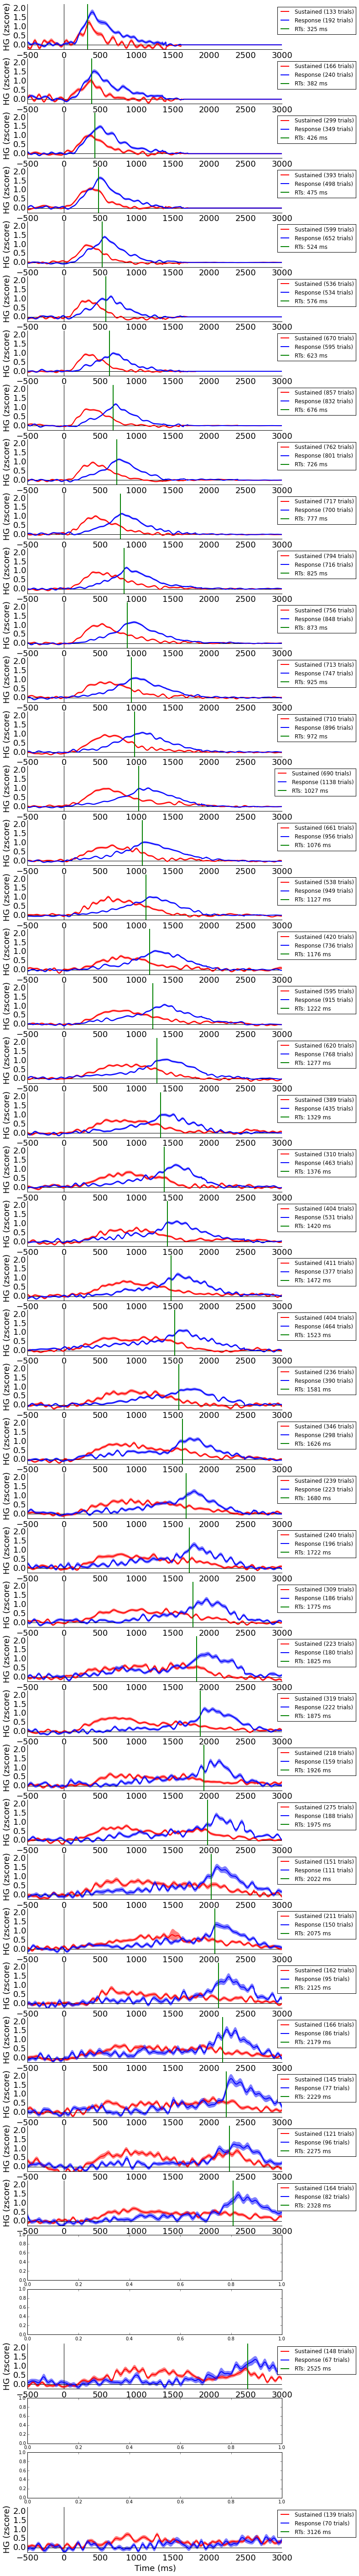

In [264]:
lats, lats_resp, rts, rts_resp, offsets, task_proportion, task_proportion_resp, lats_fromoffset = [[] for i in range(8)]
prop_dict, count_dict = [dict() for i in range(2)]

bins = np.arange(allRTs.min(), allRTs.max(), 50)
f, ax = plt.subplots(47, 1, figsize = (10,100))
#f, ax = plt.subplots(9, 1, figsize = (10,25))

cnt = 0
start_i = 0
start_i_resp = 0
new_b = 0
for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue
        
    if len(np.arange(start_i_resp, end_i_resp+1))<50:
        cnt+=1
        continue
                
#     if ((i-1) % 5 != 0) & ( i > 0): #only plot every 7th one, starting with second one
#         continue
    
    data = alldata[start_i:end_i+1,:]
    data_resp = alldata_resp[start_i_resp:end_i_resp+1,:]
    offset = alloffsets[start_i:end_i+1].mean()
    
    #extract latency
    lats.append(np.argmax(data.mean(axis =0))-500)
    lats_resp.append(np.argmax(data_resp.mean(axis = 0))-500)
    rts.append(allRTs[start_i:end_i+1].mean())
    rts_resp.append(allRTs_resp[start_i_resp:end_i_resp+1].mean())
    offsets.append(offset)
    lats_fromoffset.append(np.argmax(data.mean(axis = 0)[offset:])-500)
    
    #t1 = df_val[df_val['bin/RT'] == np.floor(rts[-1])]['t1 (D>R) ms'].values[0]
    #t2 = df_val[df_val['bin/RT'] == np.floor(rts[-1])]['t2 (last cross) ms'].values[0]
    #lastpeak = df_val[df_val['bin/RT'] == np.floor(rts[-1])]['last dur peak lat ms'].values[0]
    

    #calculate proportions
    prop_dict[cnt] = pd.Series(alltasks[start_i:end_i+1]).value_counts()/len(alltasks[start_i:end_i+1])    
    count_dict[cnt] = pd.Series(zip(alltasks[start_i:end_i+1], allsubjs[start_i:end_i+1])).value_counts()

    #save data
    #filename = os.path.join(savedir, 'trace_data', 'trace_data_%ims.mat' %(rts[-1]))
    #spio.savemat(filename, {'data':data, 'data_resp':data_resp, 'lats':lats[-1], 'lats_resp':lats_resp[-1]})
    
    #plot
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, label = 'Sustained (%i trials)' %(len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'r', label = None)

    ax[cnt].plot(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0), color = 'b', lw = 2, label = 'Response (%i trials)' %(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'blue', label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'g', lw = 2, label = 'RTs: %i ms' %(allRTs[start_i:end_i+1].mean())) 
 
    #ax[cnt].axvline(x = t1, color = 'k', ls = ':', lw = 2, label = 't1: %i ms' %(t1))
    #ax[cnt].axvline(x = t2, color  = 'k', ls = ':', lw = 2, label = 't2: %i ms' %(t2))
    #ax[cnt].plot(lastpeak, data.mean(axis = 0)[lastpeak+500], 'o', color = 'k', markersize = 5, label = 'Last peak : %i ms' %(lastpeak))
    
    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 18)
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 3000])
    
    
    ax[cnt].xaxis.set_tick_params(labelsize = 18)
    ax[cnt].yaxis.set_tick_params(labelsize = 18)
    ax[cnt].tick_params( axis='both', which = 'both', top = 'off', bottom = 'off', right = 'off', left = 'off')
    
    handles, labels = ax[cnt].get_legend_handles_labels()
    lgnd = ax[cnt].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.3,1))            
                
    cnt += 1
    
ax[cnt-1].set_xlabel('Time (ms)', fontsize = 18)
    
# #annotations for every 8th
# ax[1].annotate('RT', xy = (rts[1]+50, 1.75), color = 'g', fontsize = 14, weight = 'bold')
# ax[1].annotate('sustained', xy = (40, 1.1), color = 'r', fontsize = 14, weight = 'bold')
# ax[1].annotate('response', xy = (750, 1.1), color = 'b', fontsize = 14, weight = 'bold')
                 
filename = os.path.join(savedir, 'binned_RTs_withresp_allbins.png')

# filename = os.path.join(savedir, 'binned_RTs_withresp_every10.png')

f.savefig(filename, bbox_extra_artists=(lgnd,), bbox_inches='tight')
#f.savefig(filename,bbox_inches='tight')

#store values
# filename = os.path.join(savedir, 'binned_RTs_withresp.csv')
# df_vals = pd.DataFrame({'offsets':offsets, 'rts':rts, 'lats':lats, 'rts_resp':rts_resp, 'lats_resp':lats_resp, 'lats_fromoffset':lats_fromoffset})
# df_vals[['rts', 'rts_resp', 'lats', 'lats_fromoffset', 'lats_resp', 'offsets']].to_csv(filename, index = False)

print savedir

## Custom Bins

/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:69: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(536, 534)
(713, 747)
(620, 768)
(346, 298)
(275, 188)
(164, 82)
/home/knight/matar/MATLAB/DATA/Avgusta/PCA/Figures


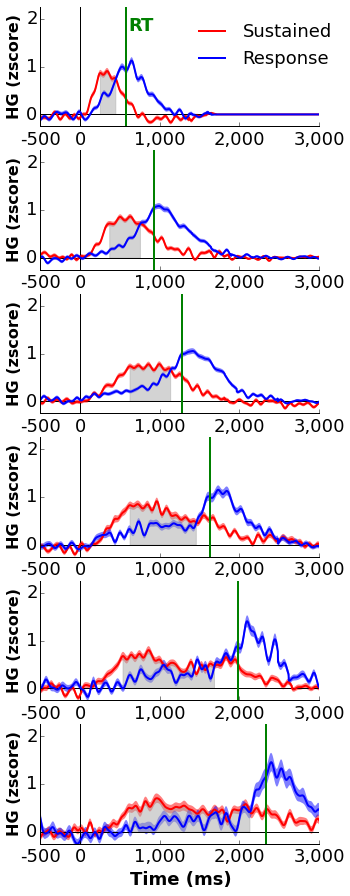

In [30]:
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL','Bin_Stats_v1_D+R.csv')
df_val = pd.read_csv(filename)

lats, lats_resp, rts, rts_resp, offsets, task_proportion, task_proportion_resp, lats_fromoffset = [[] for i in range(8)]
prop_dict, count_dict = [dict() for i in range(2)]

bins = np.arange(allRTs.min(), allRTs.max(), 50)

f, ax = plt.subplots(6, 1, figsize = (5,15))

binlist =[576, 925, 1277, 1626, 1975, 2328]

cnt = 0
start_i = 0
start_i_resp = 0
new_b = 0

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue
        
    if len(np.arange(start_i_resp, end_i_resp+1))<50:
        continue
                
    
    data = alldata[start_i:end_i+1,:]
    data_resp = alldata_resp[start_i_resp:end_i_resp+1,:]
    offset = alloffsets[start_i:end_i+1].mean()
    
    #extract latency
    lats.append(np.argmax(data.mean(axis =0))-500)
    lats_resp.append(np.argmax(data_resp.mean(axis = 0))-500)
    rts.append(allRTs[start_i:end_i+1].mean())
    rts_resp.append(allRTs_resp[start_i_resp:end_i_resp+1].mean())
    offsets.append(offset)
    lats_fromoffset.append(np.argmax(data.mean(axis = 0)[offset:])-500)
    
    idx = np.argmin(abs(rts - np.floor(rts[-1])))
    t2 = df_val.iloc[idx]['t2 (last cross)']
    t4 = df_val.iloc[idx]['1st dur peak (t4)']

    if df_val.iloc[idx]['RT'] not in (binlist):
        continue

    #plot
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)
    

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, label = 'Sustained')# (%i trials)') %(len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'r', label = None)

    ax[cnt].plot(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0), color = 'b', lw = 2, label = 'Response')# (%i trials)') %(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'blue', label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'g', lw = 2)#, label = 'RT: %i ms' %(allRTs[start_i:end_i+1].mean()))
    
    ax[cnt].fill_between(np.arange(t4, t2), 0,  data.mean(axis = 0)[t4+500:t2+500], color = 'darkgray', alpha = 0.5)

 
    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 16, fontweight = 'bold')
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 3000])
    ax[cnt].set_xticks([-500, 0, 1000, 2000, 3000])
    ax[cnt].set_yticks(np.arange(0, 3, 1))

    ax[cnt].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax[cnt].xaxis.set_tick_params(labelsize = 18)
    ax[cnt].yaxis.set_tick_params(labelsize = 18)
    #ax[cnt].tick_params( axis='both', which = 'both', top = 'off', bottom = 'off', right = 'off', left = 'off')
                    
    handles, labels = ax[0].get_legend_handles_labels()
    lgnd = ax[0].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1,1), frameon = False, fontsize = 18)
 
    print (len(allRTs[start_i:end_i+1]),(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    
    cnt += 1
    
ax[cnt-1].set_xlabel('Time (ms)', fontsize = 18, fontweight = 'bold')
            
    
    
ax[0].annotate('RT', xy = (binlist[0]+50, 1.75), color = 'g', fontsize = 18, weight = 'bold')
#ax[1].annotate('sustained', xy = (40, 1.1), color = 'r', fontsize = 14, weight = 'bold')
#ax[1].annotate('response', xy = (750, 1.1), color = 'b', fontsize = 14, weight = 'bold')
                 
filename = os.path.join(savedir, 'binned_RTs_withresp_custom_commas_legend.png')

# f.savefig(filename,bbox_inches='tight', dpi = 150)

print savedir

In [34]:
max([536, 534, 713, 747, 620, 768, 346, 298, 275, 188, 164, 82])


768

# stimulus and SR

In [268]:
#load data (without my data, without SR)
p = 'D'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata, allRTs, allsubjs, alltasks, alloffsets = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#p, c = ('S', 'limegreen')
p, c = ('SR', 'gold')
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata_stim, allRTs_stim, allsubjs_stim, alltasks_stim, alloffsets_stim = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs)
allRTs = allRTs[i]
alldata = alldata[i,:]
allsubjs = allsubjs[i]
alltasks = alltasks[i]
alloffsets = alloffsets[i]

#sort data
i = np.argsort(allRTs_stim)
allRTs_stim = allRTs_stim[i]
alldata_stim = alldata_stim[i,:]
allsubjs_stim = allsubjs_stim[i]
alltasks_stim = alltasks_stim[i]
alloffsets_stim = alloffsets_stim[i]

/home/knight/matar/MATLAB/DATA/Avgusta/PCA/Figures


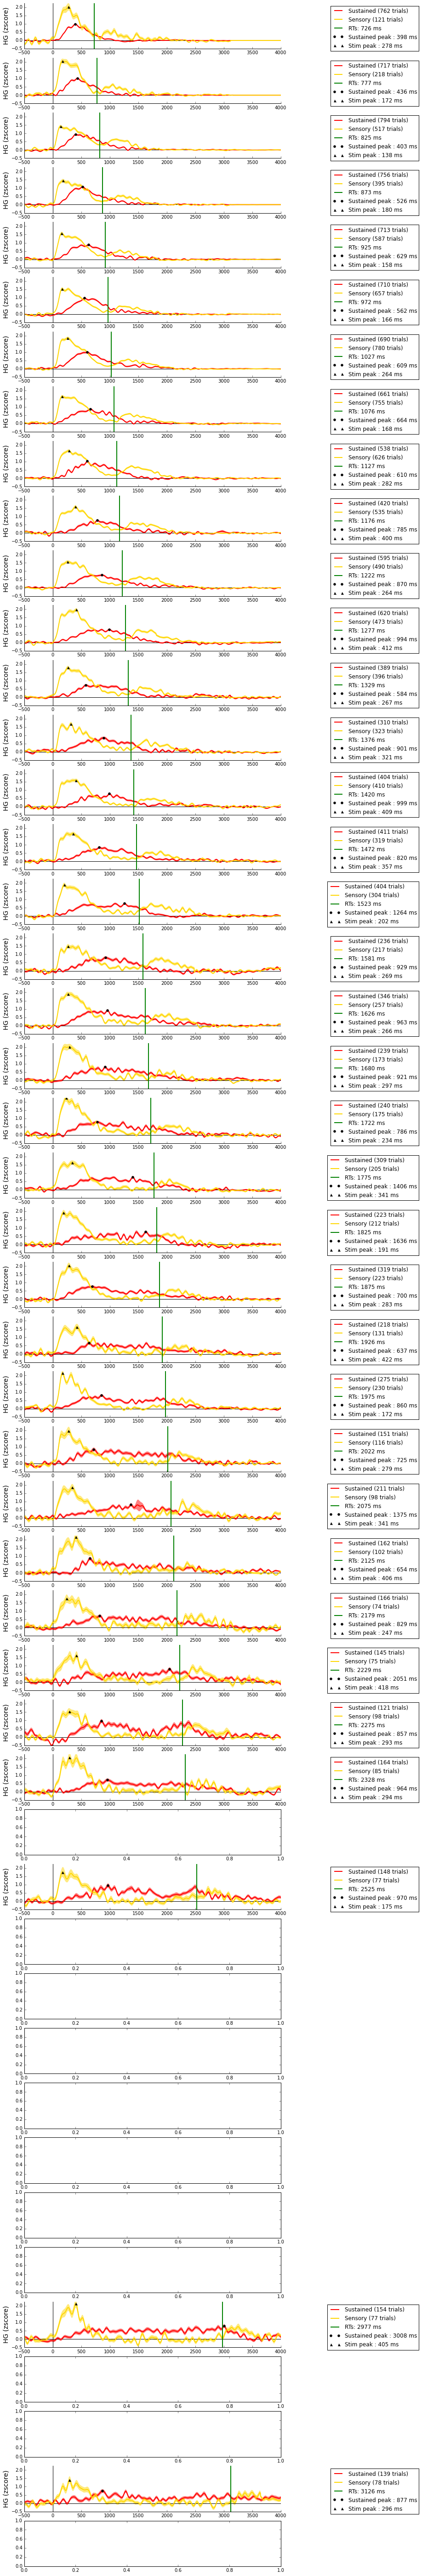

In [269]:
lats, lats_stim, rts, rts_stim, offsets, task_proportion, task_proportion_stim, lats_fromoffset = [[] for i in range(8)]
prop_dict, count_dict = [dict() for i in range(2)]

bins = np.arange(allRTs.min(), allRTs.max(), 50)
f, ax = plt.subplots(47, 1, figsize = (10,100))
#f, ax = plt.subplots(8, 1, figsize = (10,20))
cnt = 0
start_i = 0
start_i_stim = 0
new_b = 0
for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_stim = end_i_stim+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    
    if min(allRTs_stim) > (b): #all RTs in stim are bigger than current bin
        end_i_stim = -1
        continue
    end_i_stim = np.where(allRTs_stim <= (b))[-1][-1] #define resp bins based on stimulus RTs
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        cnt+=1
        continue
        
    if len(np.arange(start_i_stim, end_i_stim+1))<50:
        continue
    
    #if ((i-1) % 8 != 0) & ( i > 0): #only plot every tenth one, starting with second one
    #    continue
    
    data = alldata[start_i:end_i+1,:]
    data_stim = alldata_stim[start_i_stim:end_i_stim+1,:]
    offset = alloffsets[start_i:end_i+1].mean()
    
    #extract latency
    lats.append(np.argmax(data.mean(axis =0))-500)
    lats_stim.append(np.argmax(data_stim.mean(axis = 0))-500)
    rts.append(allRTs[start_i:end_i+1].mean())
    rts_stim.append(allRTs_stim[start_i_stim:end_i_stim+1].mean())
    offsets.append(offset)
    lats_fromoffset.append(np.argmax(data.mean(axis = 0)[offset:])-500)
    
    #t1 = df_val[df_val['bin/RT'] == np.floor(rts[-1])]['t1 (D>R) ms'].values[0]
    #t2 = df_val[df_val['bin/RT'] == np.floor(rts[-1])]['t2 (last cross) ms'].values[0]
    #lastpeak = df_val[df_val['bin/RT'] == np.floor(rts[-1])]['last dur peak lat ms'].values[0]
    

    #calculate proportions
    prop_dict[cnt] = pd.Series(alltasks[start_i:end_i+1]).value_counts()/len(alltasks[start_i:end_i+1])    
    count_dict[cnt] = pd.Series(zip(alltasks[start_i:end_i+1], allsubjs[start_i:end_i+1])).value_counts()

    #save data
    #filename = os.path.join(savedir, 'trace_data', 'trace_data_stim_%s_%ims.mat' %(p, rts[-1]))
    #spio.savemat(filename, {'data':data, 'data_stim':data_stim, 'lats':lats[-1], 'lats_stim':lats_stim[-1]})
   
    #plot
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, label = 'Sustained (%i trials)' %(len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'r', label = None)

    ax[cnt].plot(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0), color = c, lw = 2, label = 'Sensory (%i trials)' %(len(allRTs_stim[start_i_stim:end_i_stim+1])))
    sem = np.std(data_stim, axis = 0)/np.sqrt(data_stim.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0)+sem, data_stim.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = c, label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'g', lw = 2, label = 'RTs: %i ms' %(allRTs[start_i:end_i+1].mean())) 
    #ax[cnt].axvline(x = t1, color = 'k', ls = ':', lw = 2, label = 't1: %i ms' %(t1))
    #ax[cnt].axvline(x = t2, color  = 'k', ls = ':', lw = 2, label = 't2: %i ms' %(t2))
    
    #ax[cnt].plot(lastpeak, data.mean(axis = 0)[lastpeak+500], 'o', color = 'k', markersize = 5, label = 'Last peak : %i ms' %(lastpeak))

    ax[cnt].plot(lats[-1], data.mean(axis = 0)[lats[-1]+500], 'o', color = 'k', markersize = 5, label = 'Sustained peak : %i ms' %(lats[-1]))
    ax[cnt].plot(lats_stim[-1], data_stim.mean(axis = 0)[lats_stim[-1]+500], '^', color = 'k', markersize = 5, label = 'Stim peak : %i ms' %(lats_stim[-1]))
 
    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 14)
    ax[cnt].set_ylim([-0.5, 2.25])
    ax[cnt].set_xlim([-500, 4000])
    
    handles, labels = ax[cnt].get_legend_handles_labels()
    lgnd = ax[cnt].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.55,1))            
    
    cnt += 1
    
#annotations for every 8th
#ax[1].annotate('RT', xy = (rts[1]+50, 1.75), color = 'g', fontsize = 14, weight = 'bold')
#ax[1].annotate('sustained', xy = (600, 1.2), color = 'r', fontsize = 14, weight = 'bold')
#ax[1].annotate('sensory', xy = (200, 1.75), color = c, fontsize = 14, weight = 'bold')

# ax[2].annotate('RT', xy = (rts[2]+50, 1.75), color = 'g', fontsize = 14, weight = 'bold')
# ax[2].annotate('sustained', xy = (650, 1), color = 'r', fontsize = 14, weight = 'bold')
# ax[2].annotate('stimulus', xy = (50, 1.3), color = c, fontsize = 14, weight = 'bold')
                 
# filename = os.path.join(savedir, 'binned_RTs_withstim_%s_every8.png' %(p))
filename = os.path.join(savedir, 'binned_RTs_withstim_%s_allbins' %(p))

f.savefig(filename, bbox_extra_artists=(lgnd,), bbox_inches='tight')

#store values
# filename = os.path.join(savedir, 'binned_RTs_withstim_%s.csv' %(p))
# df_vals = pd.DataFrame({'offsets':offsets, 'rts':rts, 'lats':lats, 'rts_stim':rts_stim, 'lats_stim':lats_stim, 'lats_fromoffset':lats_fromoffset})
# df_vals[['rts', 'rts_stim', 'lats', 'lats_fromoffset', 'lats_stim', 'offsets']].to_csv(filename, index = False)

print savedir


## calculate difference from baseline, output csv with t values per time point

In [4]:
#load data (without my data, without SR)
p = 'D'
c = 'red'
minimum_number_of_trials = 100

#p = 'R'
#c = 'blue'
#minimum_number_of_trials = 50

# p = 'SR'
# c = 'gold'
# minimum_number_of_trials = 50

# p = 'S'
# c = 'limegreen'
# minimum_number_of_trials = 50

filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata, allRTs, allsubjs, alltasks, alloffsets = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs)
allRTs = allRTs[i]
alldata = alldata[i,:]
allsubjs = allsubjs[i]
alltasks = alltasks[i]
alloffsets = alloffsets[i]

In [5]:
bins = np.arange(allRTs.min(), allRTs.max(), 50)

num_trials, dur_dict_t, dur_dict_p = [dict() for i in range(3)]

cnt = 0
start_i = 0
new_b = 0

bl_st = -500

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
        
    if len(np.arange(start_i, end_i+1)) < minimum_number_of_trials:
        continue
    
    data = alldata[start_i:end_i+1,abs(bl_st):]
    rt = np.floor(allRTs[start_i:end_i+1].mean())
    
    
    tvals, pvals = [[] for i in range(2)]
    for j in np.arange(0, data.shape[1]):
        (t, pval) = stats.ttest_1samp(data[:,j], 0)
        tvals.append(t)
        pvals.append(pval)
    
    dur_dict_t[rt] = tvals
    dur_dict_p[rt] = pvals
    
    num_trials[rt] = alldata[start_i:end_i+1,:].shape[0]
    
    
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
pd.DataFrame(dur_dict_t).to_csv(filename, index = False)

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_pvals.csv' %(p))
pd.DataFrame(dur_dict_p).to_csv(filename, index = False)

num_trials = pd.DataFrame([num_trials]).transpose()
num_trials.columns = ['dur']
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'num_trials_%s.csv' %(p))
pd.DataFrame(num_trials).to_csv(filename)


In [6]:
#calculate threshold
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_pvals.csv' %(p))
df_p = pd.read_csv(filename)

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
df_t = pd.read_csv(filename)

minbin = num_trials.dur.argmin() #bin with least number of trials

pvals = df_p[str(minbin)] #pvalues for bin with least number of trials

thr = fdr_correct.fdr2(pvals, q = 0.05) #fdr threshold for bin with least number of trials

tvals = df_t[str(minbin)]
t_thresh  = float(tvals[pvals == thr]) #t value that corresponds to pvalue


# use threshold to define significance windows for each bin for dur and response
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
df_t = pd.read_csv(filename)

H_dur = (df_t>t_thresh).astype('int')


In [12]:
sum(H_dur)

325.0      498
382.0      521
426.0      754
475.0      723
524.0      676
576.0      580
623.0      690
676.0      748
726.0      871
777.0     1018
825.0     1270
873.0     1429
925.0     1520
972.0     1355
1027.0    1801
1076.0    1426
1127.0    1297
1176.0    1410
1222.0    1814
1277.0    1541
1329.0    1598
1376.0    1413
1420.0    1641
1472.0    2073
1523.0    1660
1581.0    1570
1626.0    2109
1680.0    2015
1722.0    1918
1775.0    1967
1825.0    1822
1875.0    2185
1926.0    2142
1975.0    2190
2022.0    2049
2075.0    2411
2125.0    2260
2179.0    2255
2229.0    2454
2275.0    2112
2328.0    2444
2425.0    1990
2479.0    2792
2525.0    3106
2728.0    2322
2977.0    3185
3126.0    3395
dtype: int64

/usr/local/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


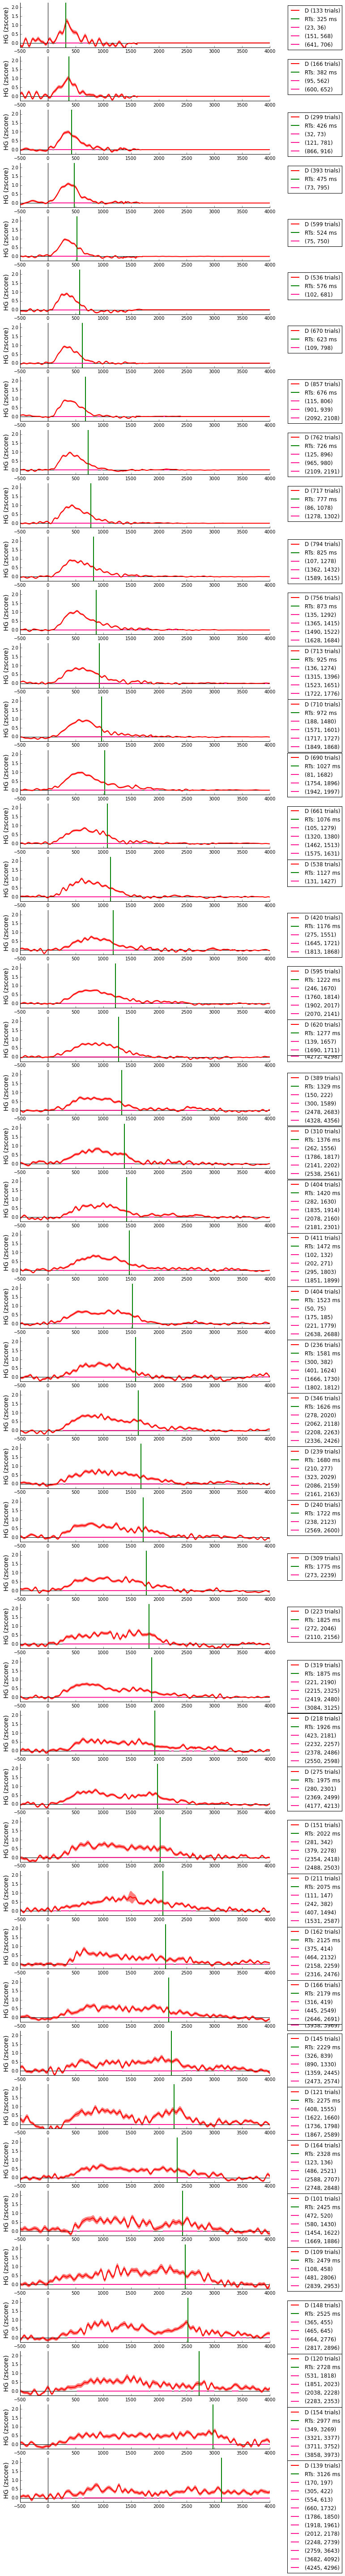

In [13]:
df_idx = pd.DataFrame(columns = ['start_idx','end_idx'])

#plot - only 1 trace withs ignificant windows on x axis
f, ax = plt.subplots(47, 1, figsize = (10,100))
rts=[]
cnt = 0
start_i = 0
start_i_resp = 0
new_b = 0
for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1)) < minimum_number_of_trials:
        continue
    
    data = alldata[start_i:end_i+1,:]
    rts.append(allRTs[start_i:end_i+1].mean())
    
    #calculate windows
    H = H_dur[str(np.floor(rts[-1]))]
    
    difference = np.diff(H, n = 1, axis = 0)
    start_idx = np.where(difference==1)[0]+1
    end_idx = np.where(difference == -1)[0]

    if start_idx.size > end_idx.size: #last chunk goes until end
        end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))

    elif start_idx.size < end_idx.size:
        start_idx = np.append(0, start_idx) #starts immediately significant

    if (start_idx.size!=0):
        if (start_idx[0] > end_idx[0]): #starts immediately significant
            start_idx = np.append(0, start_idx)

    if (start_idx.size!=0):
        if (end_idx[-1] < start_idx[-1]):#significant until end
            end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))

    #plot   
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = c, lw = 2, label = '%s (%i trials)' %(p, len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = c, label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'g', lw = 2, label = 'RTs: %i ms' %(allRTs[start_i:end_i+1].mean())) 

    if start_idx.size>0:
        for i, s in enumerate(start_idx):
            tmp = np.arange(s, end_idx[i])
            start = s
            finish = end_idx[i]
            ax[cnt].plot(tmp, np.zeros(tmp.size), color = 'deeppink', linewidth = 2, label = (start, finish))
            
        tmp = pd.DataFrame([start_idx, end_idx]).transpose()
        tmp = tmp.set_index(np.tile(np.floor(rts[-1]), len(start_idx)))
        tmp.columns = ['start_idx','end_idx']
        df_idx = df_idx.append(tmp)

    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 14)
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 4000])
    
    handles, labels = ax[cnt].get_legend_handles_labels()
    lgnd = ax[cnt].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.3,1))            
                
    cnt += 1
    
filename = os.path.join(savedir, 'trace_data','sigvalues', 'binned_RTs_sigwindow_%s.png' %(p))
f.savefig(filename, bbox_extra_artists=(lgnd,), bbox_inches='tight')

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RTs_sigwindow_%s.csv' %(p))
df_idx.to_csv(filename)


In [14]:
filename

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/Figures/trace_data/sigvalues/binned_RTs_sigwindow_D.csv'

In [114]:
df_idx.reset_index().drop_duplicates('index').iloc[5:].mean()

index        1522.578947
start_idx     362.763158
end_idx       737.500000
dtype: float64

## calculate significance windows between traces


In [55]:
#load data (without my data, without SR)
p = 'D'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata, allRTs, allsubjs, alltasks, alloffsets = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs)
allRTs = allRTs[i]
alldata = alldata[i,:]
allsubjs = allsubjs[i]
alltasks = alltasks[i]
alloffsets = alloffsets[i]

p = 'S'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata_resp, allRTs_resp, allsubjs_resp, alltasks_resp, alloffsets_resp = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs_resp)
allRTs_resp = allRTs_resp[i]
alldata_resp = alldata_resp[i,:]
allsubjs_resp = allsubjs_resp[i]
alltasks_resp = alltasks_resp[i]
alloffsets_resp = alloffsets_resp[i]


pA = 'dur'
pB = p
c = 'limegreen'
minimum_number_of_trials = 50

alldataA = alldata
alldataB = alldata_resp
allRTsB = allRTs_resp

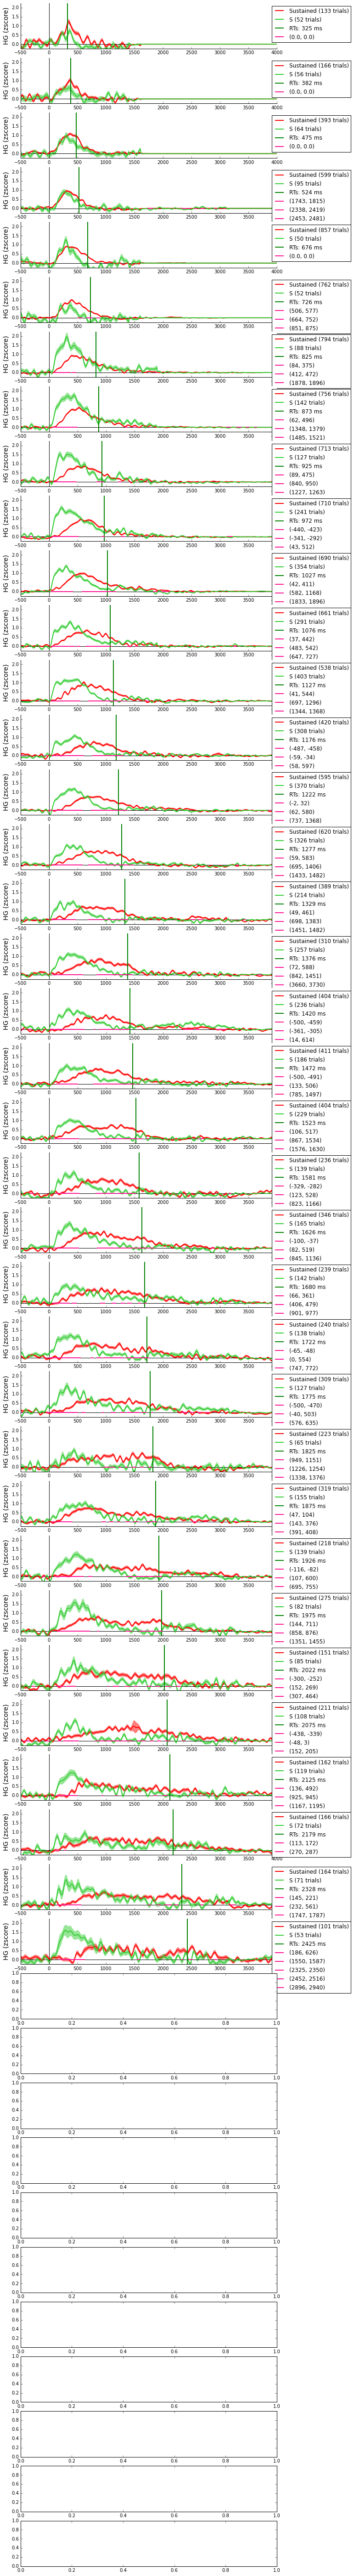

In [56]:
bins = np.arange(allRTs.min(), allRTs.max(), 50)
rts = list()
f, ax = plt.subplots(47, 1, figsize = (10,100))

df_idx = pd.DataFrame(columns = ['start_idx','end_idx'])


thresh = 0

cnt = 0
start_i = 0
start_i_resp = 0
new_b = 0

bl_st = -500
chunksize = 100

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    
    if min(allRTs_resp) > (b): 
        end_i_resp = -1
        continue
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs

    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue
        
    if len(np.arange(start_i_resp, end_i_resp+1))<minimum_number_of_trials:
        continue
    
    data = alldataA[start_i:end_i+1,:]
    dataB = alldataB[start_i_resp:end_i_resp+1,:]
    rts.append(allRTs[start_i:end_i+1].mean())

    if data.shape[1]>dataB.shape[1]:
        data = data[:,:dataB.shape[1]]
    else:
        dataB = dataB[:,:data.shape[1]]

    pvals = list()
    for j in np.arange(0, data.shape[1]):
        (t, p) = stats.ttest_ind(data[:,j], dataB[:,j])
        pvals.append(p)
    thr = fdr_correct.fdr2(pvals, q = 0.05)
    H = np.array(np.array(pvals<thr)).astype('int')

    if (thr>0):

        #find elecs with window 
        difference = np.diff(H, n = 1, axis = 0)
        start_idx = np.where(difference==1)[0]+1
        end_idx = np.where(difference == -1)[0]

        if start_idx.size > end_idx.size: #last chunk goes until end
            end_idx = np.append(end_idx, int(data.shape[1]+abs(bl_st)))

        elif start_idx.size < end_idx.size:
            start_idx = np.append(0, start_idx) #starts immediately significant

        if (start_idx.size!=0):
            if (start_idx[0] > end_idx[0]): #starts immediately significant
                start_idx = np.append(0, start_idx)

        if (start_idx.size!=0):
            if (end_idx[-1] < start_idx[-1]):#significant until end
                end_idx = np.append(end_idx, int(data.shape[1]+abs(bl_st)))
        start_idx = start_idx + bl_st
        end_idx = end_idx + bl_st
    else:
        start_idx = np.zeros((1,))
        end_idx = np.zeros((1,))
               
    #plot   
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, label = 'Sustained (%i trials)' %(len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'r', label = None)

    ax[cnt].plot(np.arange(-500, dataB.shape[1]-500), dataB.mean(axis = 0), color = c, lw = 2, label = '%s (%i trials)' %(pB, len(allRTsB[start_i_resp:end_i_resp+1])))
    sem = np.std(dataB, axis = 0)/np.sqrt(dataB.shape[0])
    ax[cnt].fill_between(np.arange(-500, dataB.shape[1]-500), dataB.mean(axis = 0)+sem, dataB.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = c, label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'g', lw = 2, label = 'RTs: %i ms' %(allRTs[start_i:end_i+1].mean())) 

    if start_idx.size>0:
        for i, s in enumerate(start_idx):
            tmp = np.arange(s, end_idx[i])
            start = s
            finish = end_idx[i]
            ax[cnt].plot(tmp, np.zeros(tmp.size), color = 'deeppink', linewidth = 2, label = (start, finish))
            
        tmp = pd.DataFrame([start_idx, end_idx]).transpose()
        tmp = tmp.set_index(np.tile(np.floor(rts[-1]), len(start_idx)))
        tmp.columns = ['start_idx','end_idx']
        df_idx = df_idx.append(tmp)

    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 14)
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 4000])
    
    handles, labels = ax[cnt].get_legend_handles_labels()
    lgnd = ax[cnt].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.3,1))            
                
    cnt += 1
    
filename = os.path.join(savedir, 'trace_data','sigvalues', 'binned_RTs_sigwindow_%s_%s.png' %(pA, pB))
f.savefig(filename, bbox_extra_artists=(lgnd,), bbox_inches='tight')

filename = os.path.join(savedir,'trace_data','sigvalues', 'binned_RTs_sigwindow_%s_%s.csv' %(pA, pB))
df_idx.to_csv(filename)
    

# first 5 bins for all traces overlayed

In [37]:
#load data (without my data, without SR)
p = 'D'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata, allRTs, allsubjs, alltasks, alloffsets = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs)
allRTs = allRTs[i]
alldata = alldata[i,:]
allsubjs = allsubjs[i]
alltasks = alltasks[i]
alloffsets = alloffsets[i]

p = 'R'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata_resp, allRTs_resp, allsubjs_resp, alltasks_resp, alloffsets_resp = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs_resp)
allRTs_resp = allRTs_resp[i]
alldata_resp = alldata_resp[i,:]
allsubjs_resp = allsubjs_resp[i]
alltasks_resp = alltasks_resp[i]
alloffsets_resp = alloffsets_resp[i]

p = 'S'
filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_nodecision_' + p + '_dropSR.mat')
data_dict = loadmat.loadmat(filename)
alldata_stim, allRTs_stim, allsubjs_stim, alltasks_stim, alloffsets_stim = [data_dict.get(key) for key in ['alldata', 'allRTs', 'allsubjs', 'alltasks', 'alloffsets']]

#sort data
i = np.argsort(allRTs_stim)
allRTs_stim = allRTs_stim[i]
alldata_stim = alldata_stim[i,:]
allsubjs_stim = allsubjs_stim[i]
alltasks_stim = alltasks_stim[i]
alloffsets_stim = alloffsets_stim[i]

TypeError: an integer is required

/home/knight/matar/MATLAB/DATA/Avgusta/PCA/Figures/binned_RTs_stim_and_resp_shortbins_550_sidebyside.png


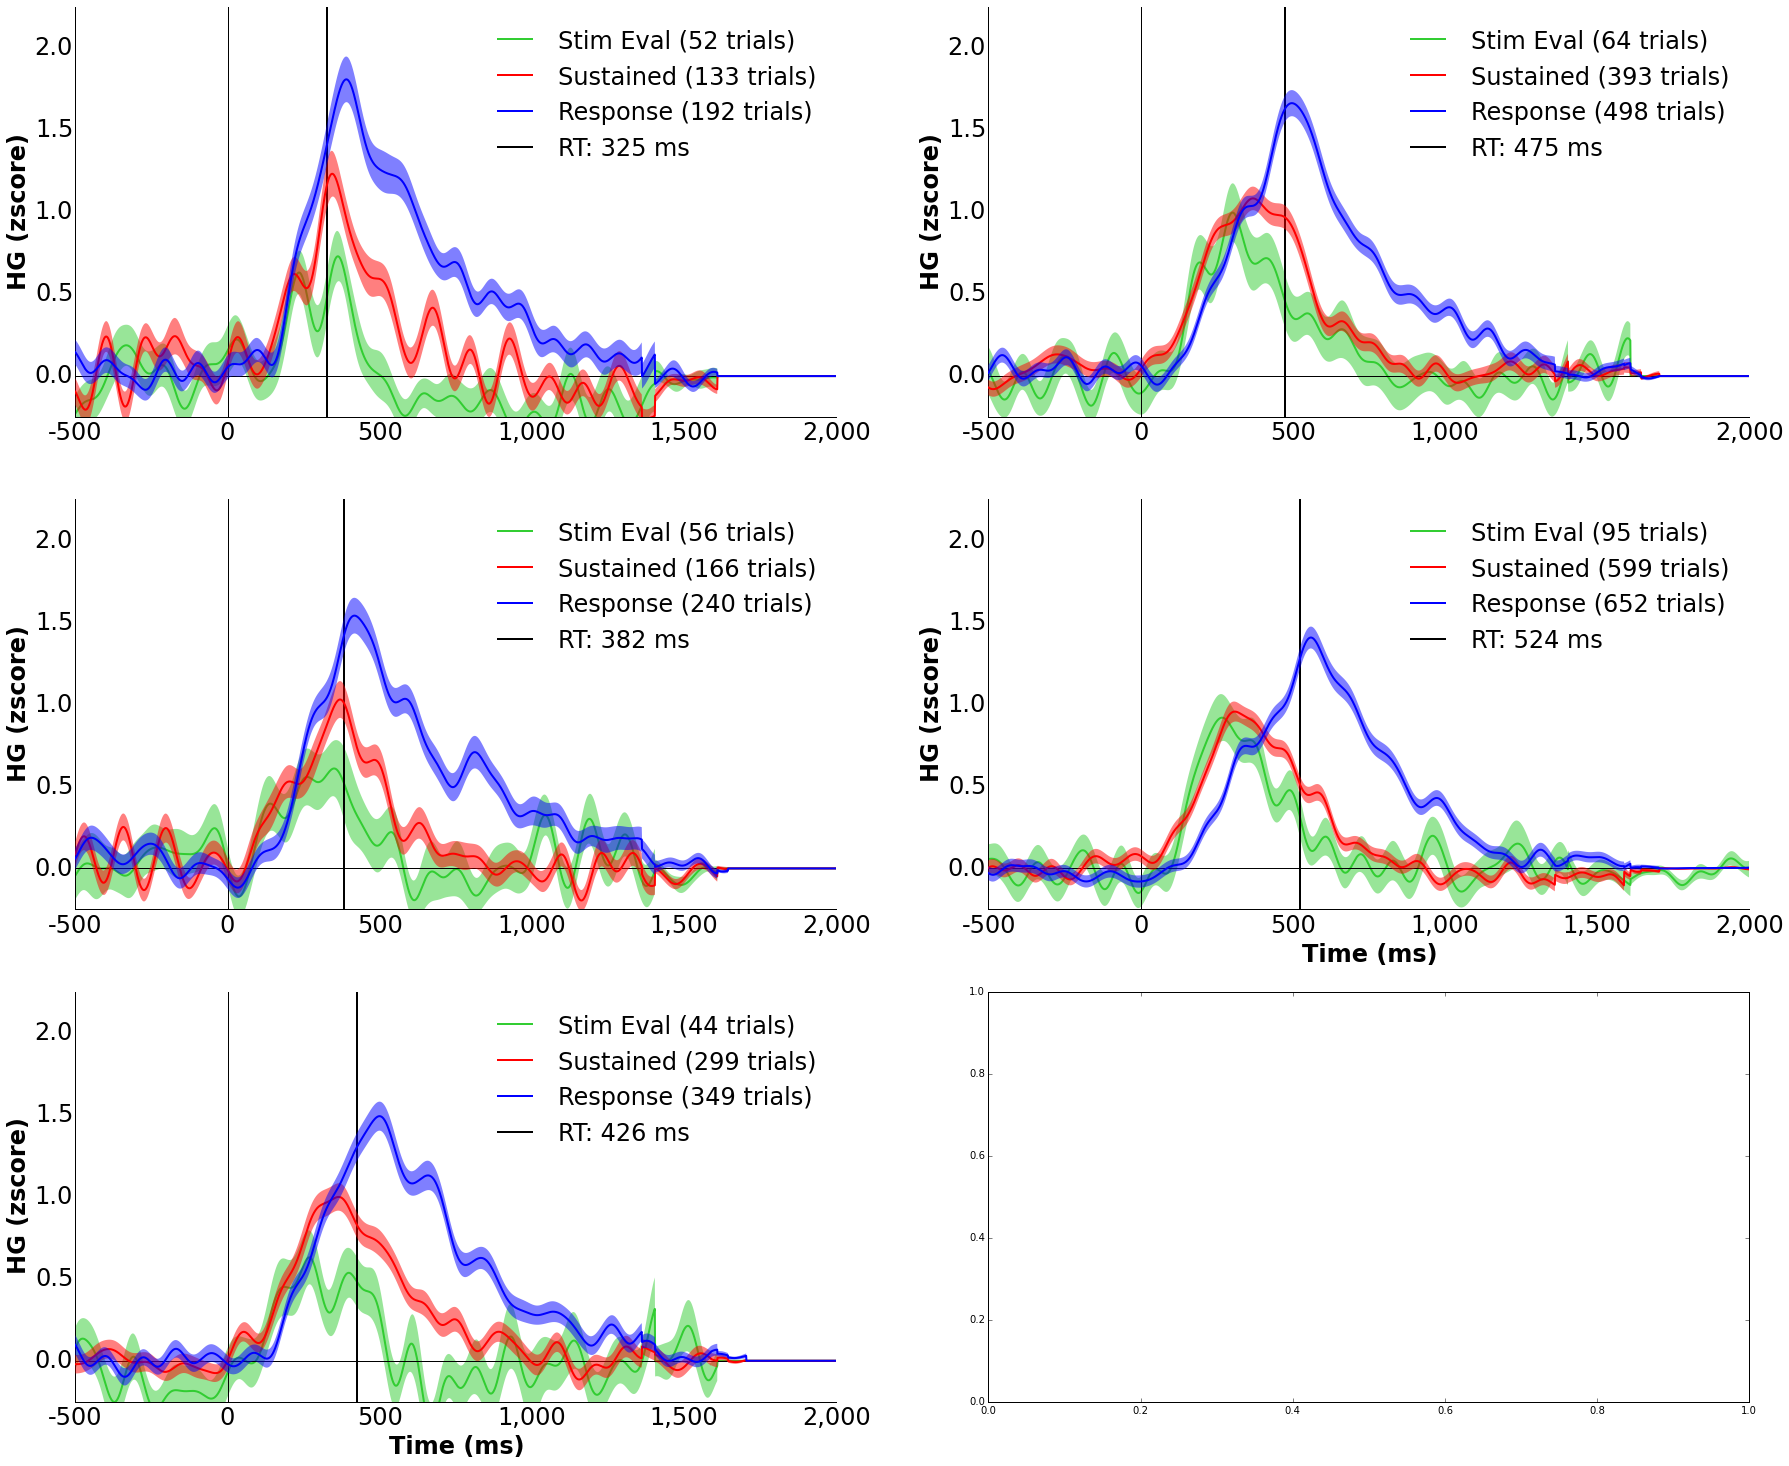

In [51]:
bins = np.arange(allRTs.min(), allRTs.max(), 50)
bins = bins[0:6] #300 - 550

f, ax = plt.subplots(3, 2, figsize = (30,25))
ax = ax.flatten() 
ax = [ax[0], ax[2], ax[4], ax[1], ax[3]] #fix ordering


cnt = 0
start_i = 0
start_i_resp = 0
start_i_stim = 0
new_b = 0

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
        start_i_stim = end_i_stim+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs
    end_i_stim = np.where(allRTs_stim<= (b))[-1][-1]
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue
        
    #if len(np.arange(start_i_resp, end_i_resp+1))<50:
    #    continue
        
    #if len(np.arange(start_i_stim, end_i_stim+1))<50:
    #    continue

    data = alldata[start_i:end_i+1,:] #cut off at 2000
    data_resp = alldata_resp[start_i_resp:end_i_resp+1,:]
    data_stim = alldata_stim[start_i_stim:end_i_stim+1,:]
    offset = alloffsets[start_i:end_i+1].mean()
       
    #plot
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)

    ax[cnt].plot(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0), color = 'limegreen', lw = 2, zorder = 0, label = 'Stim Eval (%i trials)' %(len(allRTs_stim[start_i_stim:end_i_stim+1])))
    sem = np.std(data_stim, axis = 0)/np.sqrt(data_stim.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0)+sem, data_stim.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'limegreen', label = None)

    
    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, zorder = 9, label = 'Sustained (%i trials)' %(len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 9, edgecolor = 'None', facecolor = 'r', label = None)

    ax[cnt].plot(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0), color = 'b', lw = 2, zorder = 10, label = 'Response (%i trials)' %(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 10, edgecolor = 'None', facecolor = 'blue', label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'k', lw = 2, label = 'RT: %i ms' %(allRTs[start_i:end_i+1].mean())) 
 
    #ax[cnt].axvline(x = t1, color = 'k', ls = ':', lw = 2, label = 't1: %i ms' %(t1))
    #ax[cnt].axvline(x = t2, color  = 'k', ls = ':', lw = 2, label = 't2: %i ms' %(t2))
    #ax[cnt].plot(lastpeak, data.mean(axis = 0)[lastpeak+500], 'o', color = 'k', markersize = 5, label = 'Last peak : %i ms' %(lastpeak))
    
    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 24, fontweight = 'bold')
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 2000])
    
    
    ax[cnt].xaxis.set_tick_params(labelsize = 24)
    ax[cnt].yaxis.set_tick_params(labelsize = 24)
    ax[cnt].tick_params( axis='both', which = 'both', top = 'off', bottom = 'off', right = 'off', left = 'off')
    ax[cnt].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    handles, labels = ax[cnt].get_legend_handles_labels()
    lgnd = ax[cnt].legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1), fontsize = 24, frameon = False)
                
    cnt += 1
    
ax[cnt-1].set_xlabel('Time (ms)', fontsize = 24, fontweight = 'bold')
ax[cnt-3].set_xlabel('Time (ms)', fontsize = 24, fontweight = 'bold')


filename = os.path.join(savedir, 'binned_RTs_stim_and_resp_shortbins_550_sidebyside.png')
print(filename)
f.savefig(filename, bbox_extra_artists=(lgnd,), bbox_inches='tight', dpi = 150)

# annotate trace with t1, t2, t3

In [115]:
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL','Bin_Stats_v1_D+R.csv')
df_val = pd.read_csv(filename)
df_val.head()

RT  t1 (D>R)  t2 (last cross)  t3 (R=D end)  1st dur peak (t4)  \
0  325       130              212          1506                346   
1  382        26              228          1611                370   
2  426        -2              341          1523                366   
3  475         7              389          1388                276   
4  524        52              406          1833                310   

   last dur peak  dur peak lat  dur peak amp  resp peak lat  resp peak amp  \
0            346           344          1.23            390           1.81   
1            370           370          1.03            417           1.54   
2            366           365          1.00            499           1.49   
3            370           369          1.08            497           1.66   
4            310           310          0.96            559           1.41   

   AUC Dur (t4:t2)  mean Dur (t4:t2)  AUC Resp (t2:t3)  mean Resp (t2:t3)  \
0             0.00               NaN            806.79               0.62   
1             0.00               NaN            753.95               0.54   
2             0.00               NaN            682.89               0.58   
3           114.76              1.01            658.04               0.66   
4            87.76              0.90            575.21               0.40   

   AUC Resp (t4:t2)  mean (Resp(t4:t2)  AUC Dur (t1:t2)  mean Dur (t1:t2)  \
0              0.00                NaN            30.10              0.36   
1              0.00                NaN            55.52              0.27   
2              0.00                NaN           153.75              0.45   
3            107.04               0.94           226.67              0.59   
4             72.04               0.74           209.75              0.59   

   AUC Resp (t1:t2)  mean Resp (t1:t2)  
0             19.74               0.24  
1             21.94               0.11  
2            102.37               0.30  
3            164.35               0.43  
4            120.50               0.34

In [168]:
data[:, t4:t2].mean(axis = 0).shape
np.arange(t4,t2).shape


(386,)

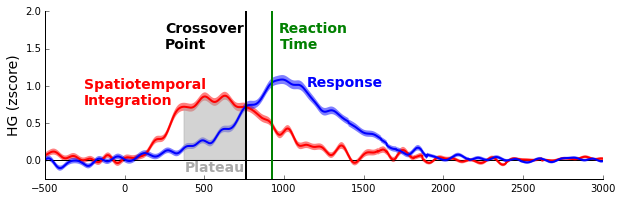

In [191]:
i = 925

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL','Bin_Stats_v1_D+R.csv')
df_val = pd.read_csv(filename)

filename = os.path.join(savedir, 'trace_data', 'trace_data_%ims.mat' %(i))
data_dict = loadmat.loadmat(filename)

[data, data_resp] = [data_dict[k] for k in ['data','data_resp']]

t2 = df_val[df_val['RT'] == i]['t2 (last cross)'].values[0]
t4 = df_val[df_val['RT'] == i]['1st dur peak (t4)'].values[0]

f, ax = plt.subplots(figsize = (10, 3))

#plot
ax.axhline(y = 0, color = 'k', lw = 1)
#ax.axvline(x = 0, color = 'k', lw = 1)

ax.plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, label = 'Sustained')
sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
ax.fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'red', label = None)
ax.annotate('Spatiotemporal\nIntegration', xy = (-250,.75), color= 'r', fontsize = 14, fontweight = 'bold')

ax.plot(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0), color = 'b', lw = 2, label = 'Response')
sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
ax.fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'blue', label = None)
ax.annotate('Response', xy = (1150,1), color= 'b', fontsize = 14, fontweight = 'bold')

ax.fill_between(np.arange(t4, t2), 0,  data.mean(axis = 0)[t4+500:t2+500], color = 'darkgray', zorder = 0, alpha = 0.5)
ax.annotate('Plateau', xy = (t4+10, -0.15), fontsize = 14, weight = 'bold', color = 'darkgray')

ax.axvline(x = i, color = 'g', lw = 2)
ax.annotate('Reaction\nTime', xy = (i+50, 1.5), color = 'g', fontsize = 14, weight = 'bold')

ax.axvline(x = t2, color  = 'k', lw = 2)
ax.annotate('Crossover\nPoint', xy = (t2-500, 1.5), fontsize = 14, weight = 'bold')

ax.autoscale(tight = True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('HG (zscore)', fontsize = 14)
ax.set_ylim([-0.25, 2])
ax.set_xlim([-500, 3000])

filename = os.path.join(savedir, 'binned_RTs_blank.png')
plt.savefig(filename)

In [118]:
t4

373